In [13]:
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.misc
import json
from sklearn.neighbors import KNeighborsClassifier
from scipy.spatial.distance import cdist
from sklearn.metrics import f1_score
import pickle
from utils import *

file_path = '/export/home/qliu24/VC_adv_data/feng/'
vc = 0
fake_dic = json.load(open(file_path+ 'feng_vc' + str(vc) + '_fake', 'r'))
# real_dic = json.load(open(file_path+ 'vc' + str(vc) + 'real', 'r'))
fake_code4 = np.array(fake_dic['fake_code4'])
# fake_code4[vc,vc] = False
fake_code3 = np.array(fake_dic['fake_code3'])

# real_code4 = np.array(real_dic['real_code4'])
# real_code3 = np.array(real_dic['real_code3'])[real_code4[:,vc]]
# real_code3 = np.array(real_dic['real_code3'])

# fake_code3 = np.delete(fake_code3, (vc, ), axis=0)
print(vc)
# print(get_stats(real_code3))
print(get_stats(fake_code3))

ori_dic = json.load(open(file_path+ 'feng_vc' + str(vc) + '_fake_ori', 'r'))
ori4 = np.array(ori_dic['ori4'])
ori_dis4 = np.array(ori_dic['ori_dis4'])
ori_code4 = np.array(ori_dic['ori_code4'])

real_dic = json.load(open(file_path+ 'vc' + str(vc) + '_real', 'r'))
real_code4 = np.array(real_dic['real_code4'])
real_code3 = np.array(real_dic['real_code3'])

print(fake_code4.shape, fake_code3.shape)
print(ori4.shape, ori_dis4.shape, ori_code4.shape)
print(real_code4.shape, real_code3.shape)
msk_fake = np.logical_and(np.logical_not(ori_code4[:,vc]), fake_code4[:,vc])
print(np.sum(fake_code4[:,vc]), np.sum(msk_fake), np.sum(real_code4[:,vc]))
msk_real = real_code4[:,vc]
msk = np.concatenate([msk_fake, msk_real], axis=0)
concat = np.concatenate((fake_code3, real_code3), axis=0)
print(concat.shape)
concat = concat[msk]
print(concat.shape)

0
([2.87146875, 1.2518552564125824], [0.28155468750000001, 0.13990712578426748])
(2000, 200) (2000, 8, 8, 200)
(2000, 512) (2000, 200) (2000, 200)
(2000, 200) (2000, 8, 8, 200)
771 743 1999
(4000, 8, 8, 200)
(2742, 8, 8, 200)


In [14]:
fname = file_path + 'simmat_vc{}.pickle'.format(vc)
with open(fname, 'rb') as fh:
    mat1, mat2 = pickle.load(fh)
    
mat = mat1
print(mat.shape)
N = mat.shape[0]
mat_full = mat + mat.T - np.ones((N,N))
np.fill_diagonal(mat_full, 0)

(2742, 2742)


In [18]:
N_f = np.sum(msk_fake)
N_r = np.sum(msk_real)
label1 = np.concatenate((np.zeros((N_f, )), np.ones((N_r, ))), axis=0)
label2 = np.concatenate((np.ones((N_f, )), np.zeros((N_r, ))), axis=0)

kk=5
predict1 = knn_cls_no_neg(kk, mat_full, N_f, N_r, 1, coef_std=2)
predict2 = knn_cls_no_neg(kk, mat_full, N_f, N_r, 0, coef_std=2)
print("{0},{1},{2}".format(f1_score(label1, predict1), f1_score(label2, predict2), np.sum(label1[0:N_f] == predict1[0:N_f])/N_f))

0.9323308270676691,0.7950036737692872,0.7281292059219381


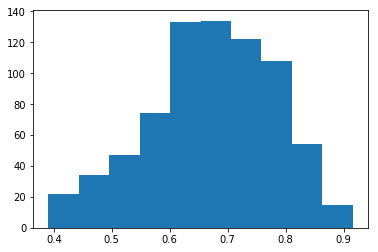

In [19]:
ori_dis_vc = ori_dis4[:,vc][msk_fake]
plt.hist(ori_dis_vc)
plt.show()

In [22]:
pctl0 = 0
pctl1 = np.percentile(ori_dis_vc, 25)
pctl2 = np.percentile(ori_dis_vc, 50)
pctl3 = np.percentile(ori_dis_vc, 75)
pctl4 = 1.0
print(pctl1, pctl2, pctl3)

# pctl1= 0.55
# pctl2 = 0.65
# pctl3 = 0.75

pctl_ls = [pctl0, pctl1, pctl2, pctl3, pctl4]
for p1,p2 in zip(pctl_ls[0:-1], pctl_ls[1:]):
    msk_pctl = np.logical_and(ori_dis_vc>=p1, ori_dis_vc<p2)
    N_f2 = np.sum(msk_pctl)
    msk_concat = np.concatenate([msk_pctl, np.ones(N_r).astype(bool)], axis=0)
    label1_pctl = label1[msk_concat]
    label2_pctl = label2[msk_concat]
    mat_full_pctl = mat_full[msk_concat][:,msk_concat]
    kk=5
    predict1 = knn_cls_no_neg(kk, mat_full_pctl, N_f2, N_r, 1, coef_std=2)
    predict2 = knn_cls_no_neg(kk, mat_full_pctl, N_f2, N_r, 0, coef_std=2)
    print("{0},{1},{2}".format(f1_score(label1_pctl, predict1), f1_score(label2_pctl, predict2), np.sum(label1_pctl[0:N_f2] == predict1[0:N_f2])/N_f2))

0.60377572629 0.677971334576 0.754246406753
0.9586034912718204,0.5388888888888889,0.521505376344086
0.964133433659393,0.6246719160104987,0.6432432432432432
0.9711975745325923,0.7233009708737863,0.8010752688172043
0.9778682269142712,0.8018223234624146,0.946236559139785


In [5]:
# fake_code3 = fake_code3.reshape((fake_code3.shape[0], -1), order='F')
# real_code3 = real_code3.reshape((real_code3.shape[0], -1), order='F')

concat = np.concatenate((fake_code3, real_code3), axis=0)
label = np.concatenate((np.zeros((fake_code3.shape[0], )), np.ones((real_code3.shape[0], ))), axis=0)

print(concat.shape, label.shape)

(2207, 6, 6, 223) (2207,)


In [6]:
mat_contents = sio.loadmat('/export/home/qliu24/qing_voting_139/qing_voting_py/intermediate/dictionary/dictionary_imagenet_car_vgg16_pool4_K176_norm_nowarp_prune_512.mat')
centers = np.array(mat_contents['centers']).T
c_dist = cdist(real_code4, centers)

dict_keys(['__header__', '__version__', '__globals__', 'centers'])


In [5]:
vc = 0
fake_dic = json.load(open(file_path+ 'vc' + str(vc) + 'fake', 'r'))
real_dic = json.load(open(file_path+ 'vc' + str(vc) + 'real', 'r'))
real_code4 = np.array(real_dic['real_code4'])
real_code4[2742, :]

array([False,  True, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [52]:
file_path = '/export/home/qliu24/VC_adv_data/'
for vc in range(5):
    print(vc)
    fake_dic = json.load(open(file_path+ 'vc' + str(vc) + 'fake', 'r'))
    real_dic = json.load(open(file_path+ 'vc' + str(vc) + 'real', 'r'))

    real_code4 = np.array(real_dic['real_code4'])
    fake_code4 = np.array(fake_dic['fake_code4'])
    if not np.all(fake_code4[:,vc]):
        print(vc, np.sum(fake_code4[:,vc]==False))
    

0
0 44
1
1 48
2
2 65
3
3 50
4
4 64


In [20]:
import numpy as np
import pickle
import random
import matplotlib.pyplot as plt
import scipy.misc
import json
from sklearn.neighbors import KNeighborsClassifier
from scipy.spatial.distance import cdist
from sklearn.metrics import f1_score

def knn_cls_on_train(K, mat_dis, label):
    np.fill_diagonal(mat_dis, 9999)
    N = mat_dis.shape[0]
    rst = np.zeros(N)
    for nn in range(N):
        nn_idx = np.argsort(mat_dis[nn])[0:K]
        rst[nn] = np.rint(np.sum(label[nn_idx])/K)
        
    return rst


file_path = '/export/home/qliu24/VC_adv_data/'
for vc in range(0,10):
    fake_dic = json.load(open(file_path+ 'vc' + str(vc) + 'fake', 'r'))
    real_dic = json.load(open(file_path+ 'vc' + str(vc) + 'real', 'r'))

    fake_code4 = np.array(fake_dic['fake_code4'])
    fake_code4 = np.delete(fake_code4, (vc, ), axis=0)
    real_code4 = np.array(real_dic['real_code4'])
    
    msk = np.concatenate([fake_code4[:,vc], real_code4[:,vc]], axis=0)
    
    # fake_code4[vc,vc] = False
    # fake_code3 = np.array(fake_dic['fake_code3'])[fake_code4[:,vc]]

    # real_code4 = np.array(real_dic['real_code4'])
    # real_code3 = np.array(real_dic['real_code3'])[real_code4[:,vc]]

    fake_code3 = np.array(fake_dic['fake_code3'])
    real_code3 = np.array(real_dic['real_code3'])
    fake_code3 = np.delete(fake_code3, (vc, ), axis=0)
    concat = np.concatenate((fake_code3, real_code3), axis=0)
    
    N = concat.shape[0]
    N_f = fake_code3.shape[0]
    N_r = real_code3.shape[0]
    
    label1 = np.concatenate((np.zeros((N_f, )), np.ones((N_r, ))), axis=0)
    label2 = np.concatenate((np.ones((N_f, )), np.zeros((N_r, ))), axis=0)
    

    with open(file_path + 'simmat_vc{0}.pickle'.format(vc),'rb') as fh:
        mat_dis1, mat_dis2 = pickle.load(fh)

    mat_full = mat_dis2 + mat_dis2.T - np.ones((N,N))
    np.fill_diagonal(mat_full, 0)
    
    label1 = label1[msk]
    label2 = label2[msk]
    mat_full = mat_full[msk][:,msk]
    N_f = np.sum(fake_code4[:,vc])
    
    predict1 = knn_cls_on_train(5, mat_full, label1)
    predict2 = knn_cls_on_train(5, mat_full, label2)
    print("{0},{1},{2}".format(f1_score(label1, predict1), f1_score(label2, predict2), np.sum(label1[0:N_f] == predict1[0:N_f])/N_f))

0.9849486566324378,0.3184713375796178,0.19083969465648856
0.9762878168438267,0.4790419161676647,0.31496062992125984
0.9782559964133603,0.21138211382113822,0.11818181818181818
0.9675583380762663,0.7046632124352332,0.544
0.9726166328600405,0.6785714285714285,0.5135135135135135
0.9783338419285933,0.5847953216374269,0.4166666666666667
0.985118560915781,0.06185567010309278,0.031914893617021274
0.9455128205128206,0.4069767441860465,0.26515151515151514
0.9438775510204083,0.794392523364486,0.6640625
0.9708613512648094,0.48,0.3181818181818182


In [14]:
from sklearn.manifold import TSNE

for vc in range(5,10):
    # print(vc)
    fake_dic = json.load(open(file_path+ 'vc' + str(vc) + 'fake', 'r'))
    real_dic = json.load(open(file_path+ 'vc' + str(vc) + 'real', 'r'))
    
    fake_code4 = np.array(fake_dic['fake_code4'])
    fake_code4 = np.delete(fake_code4, (vc, ), axis=0)
    real_code4 = np.array(real_dic['real_code4'])
    
    msk = np.concatenate([fake_code4[:,vc], real_code4[:,vc]], axis=0)
    
    fake_code3 = np.array(fake_dic['fake_code3'])
    real_code3 = np.array(real_dic['real_code3'])
    fake_code3 = np.delete(fake_code3, (vc, ), axis=0)
    concat = np.concatenate((fake_code3, real_code3), axis=0)
    
    N = concat.shape[0]
    N_f = fake_code3.shape[0]
    N_r = real_code3.shape[0]
    
    label1 = np.concatenate((np.zeros((N_f, )), np.ones((N_r, ))), axis=0)
    label2 = np.concatenate((np.ones((N_f, )), np.zeros((N_r, ))), axis=0)
    
    with open(file_path + 'simmat_vc{0}.pickle'.format(vc),'rb') as fh:
        mat_dis1, mat_dis2 = pickle.load(fh)

    mat_full = mat_dis1 + mat_dis1.T - np.ones((N,N))
    np.fill_diagonal(mat_full, 0)
    
    label1 = label1[msk]
    label2 = label2[msk]
    mat_full = mat_full[msk][:,msk]
    N_f = np.sum(fake_code4[:,vc])
    
    model = TSNE(metric="precomputed")
    tsne_v = model.fit_transform(mat_full)
    mat_dis = cdist(tsne_v, tsne_v)

    predict1 = knn_cls_on_train(5, mat_dis, label1)
    predict2 = knn_cls_on_train(5, mat_dis, label2)
    print("{0},{1},{2}".format(f1_score(label1, predict1), f1_score(label2, predict2), np.sum(label1[0:N_f] == predict1[0:N_f])/N_f))

0.9845869297163995,0.7549019607843137,0.6416666666666667
0.9836065573770493,0.10714285714285714,0.06382978723404255
0.9469026548672566,0.5932203389830509,0.5303030303030303
0.9774236387782204,0.9306122448979591,0.890625
0.9824104234527687,0.763157894736842,0.6590909090909091


In [ ]:
# double check with Huiyu's Euclidean distance result
from scipy.spatial.distance import cdist

vc = 0
fake_dic = json.load(open(file_path+ 'vc' + str(vc) + 'fake', 'r'))
real_dic = json.load(open(file_path+ 'vc' + str(vc) + 'real', 'r'))

fake_code3 = np.array(fake_dic['fake_code3'])
real_code3 = np.array(real_dic['real_code3'])
fake_code3 = np.delete(fake_code3, (vc, ), axis=0)
concat = np.concatenate((fake_code3, real_code3), axis=0)
label1 = np.concatenate((np.zeros((fake_code3.shape[0], )), np.ones((real_code3.shape[0], ))), axis=0)
label2 = np.concatenate((np.ones((fake_code3.shape[0], )), np.zeros((real_code3.shape[0], ))), axis=0)

N = concat.shape[0]
print(N)
mat_dis = cdist(concat.reshape(N,-1), concat.reshape(N,-1))
print(mat_dis.shape)

predict1 = knn_cls_on_train(5, mat_dis, label1)
predict2 = knn_cls_on_train(5, mat_dis, label2)
print(f1_score(label1, predict1), f1_score(label2, predict2))
print(np.sum(label1[0:N_f] == predict1[0:N_f])/N_f)

In [16]:
# check whether we can do KNN without fake samples (define a distance to distinguish real and fake)
import numpy as np
import pickle
import random
import matplotlib.pyplot as plt
import scipy.misc
import json
from scipy.spatial.distance import cdist
from sklearn.metrics import f1_score

def knn_cls_no_neg(K, mat_dis, N_f, N_r, real_label):
    N = mat_dis.shape[0]
    assert(N==N_r+N_f)
    np.fill_diagonal(mat_dis, 9999)
    real_dis_ls = np.array([])
    real_mat = mat_dis[N_f:N, N_f:N]
    for nr in range(N_r):
        idx_sort = np.argsort(real_mat[nr])[0:5]
        real_dis_ls = np.append(real_dis_ls, real_mat[nr, idx_sort])
        
    thrh = np.mean(real_dis_ls) + np.std(real_dis_ls)
    
    rst = np.zeros(N)
    mat_dis_obs = mat_dis[:, N_f:N]
    for nn in range(N):
        nn_idx = np.argsort(mat_dis_obs[nn])[0:K]
        if np.sum(mat_dis_obs[nn, nn_idx]<thrh)/K < 0.5:
            rst[nn] = 1-real_label
        else:
            rst[nn] = real_label
        
    return rst


file_path = '/export/home/qliu24/VC_adv_data/'
for vc in range(0,10):
    fake_dic = json.load(open(file_path+ 'vc' + str(vc) + 'fake', 'r'))
    real_dic = json.load(open(file_path+ 'vc' + str(vc) + 'real', 'r'))

    fake_code4 = np.array(fake_dic['fake_code4'])
    fake_code4 = np.delete(fake_code4, (vc, ), axis=0)
    real_code4 = np.array(real_dic['real_code4'])
    
    msk = np.concatenate([fake_code4[:,vc], real_code4[:,vc]], axis=0)
    
    # fake_code4[vc,vc] = False
    # fake_code3 = np.array(fake_dic['fake_code3'])[fake_code4[:,vc]]

    # real_code4 = np.array(real_dic['real_code4'])
    # real_code3 = np.array(real_dic['real_code3'])[real_code4[:,vc]]

    fake_code3 = np.array(fake_dic['fake_code3'])
    fake_code3 = np.delete(fake_code3, (vc, ), axis=0)
    real_code3 = np.array(real_dic['real_code3'])
    
    concat = np.concatenate((fake_code3, real_code3), axis=0)
    
    N = concat.shape[0]
    N_f = fake_code3.shape[0]
    N_r = real_code3.shape[0]
    
    label1 = np.concatenate((np.zeros((N_f, )), np.ones((N_r, ))), axis=0)
    label2 = np.concatenate((np.ones((N_f, )), np.zeros((N_r, ))), axis=0)
    

    with open(file_path + 'simmat_vc{0}.pickle'.format(vc),'rb') as fh:
        mat_dis1, mat_dis2 = pickle.load(fh)

    mat_full = mat_dis2 + mat_dis2.T - np.ones((N,N))
    np.fill_diagonal(mat_full, 0)
    
    label1 = label1[msk]
    label2 = label2[msk]
    mat_full = mat_full[msk][:,msk]
    N_r = np.sum(real_code4[:,vc])
    N_f = np.sum(fake_code4[:,vc])
    N = mat_full.shape[0]
    try:
        assert(N==N_r+N_f)
    except:
        print(N_f, N_r, N)
    
    kk=5
    
    '''
    np.fill_diagonal(mat_full, 9999)
    
    real_dis_ls = np.array([])
    real_mat = mat_full[N_f:N, N_f:N]
    for nr in range(N_r):
        idx_sort = np.argsort(real_mat[nr])[0:5]
        real_dis_ls = np.append(real_dis_ls, real_mat[nr, idx_sort])
        
    fake_dis_ls = np.array([])
    fake_mat = mat_full[0:N_f, N_f:N]
    for nf in range(N_f):
        idx_sort = np.argsort(fake_mat[nf])[0:5]
        fake_dis_ls = np.append(fake_dis_ls, fake_mat[nf, idx_sort])
        
    print(np.mean(real_dis_ls), np.std(real_dis_ls), np.mean(fake_dis_ls), np.std(fake_dis_ls))
    '''
    
    predict1 = knn_cls_no_neg(kk, mat_full, N_f, N_r, 1)
    predict2 = knn_cls_no_neg(kk, mat_full, N_f, N_r, 0)
    print("{0},{1},{2}".format(f1_score(label1, predict1), f1_score(label2, predict2), np.sum(label1[0:N_f] == predict1[0:N_f])/N_f))

0.9094304388422035,0.3071428571428571,0.9847328244274809
0.9054878048780488,0.4424460431654676,0.968503937007874
0.9104514841606386,0.3756521739130435,0.9818181818181818
0.9081567116249197,0.6361323155216285,1.0
0.9233351986569669,0.6118980169971671,0.972972972972973
0.9100169779286927,0.4731610337972167,0.9916666666666667
0.9231868524473027,0.2996742671009772,0.9787234042553191
0.9073170731707316,0.6237623762376238,0.9545454545454546
0.9106881405563689,0.8063492063492065,0.9921875
0.9105806911293196,0.48879837067209775,0.9090909090909091


In [4]:
np.sum(real_code3[:,vc])

207090

In [11]:
!pwd

/export/home/qliu24/qing_voting_139/qing_clustering
